# Analysis of Latent Space Reaction Attribute Vector for Ketone Reduction to Alcohol

_Prepared by: Chih-Wei Hsu, Liang Xu, Christine Chang_

### Alcohol $(R=O)$ $\rightarrow$ Ether $(R-OH)$

This notebook uses the average reaction vector method to perform three tasks for alcohol dehydration as follow:
* Calculate the average and std dev of angle and magnitude of each vectors of reaction path,
* Calculate the difference between the predicted vectors and the actual vectors,
* Perform a deeper analysis of the molecules generated within 1 std dev of the average vector.

### Goal

Our goal is to evaluate the encoding of chemical reactions in DarkChem's latent space.  To do this, we are exploring the possibility of attribute vector arithmetic, e.g.

$\Big( \overrightarrow{product_{1}} - \overrightarrow{reactant_{1}} \Big) = \overrightarrow{reaction} \stackrel{?}{=} \Big( \overrightarrow{product_{2}} - \overrightarrow{reactant_{2}} \Big)$

### Approach

Our approach differs from prior analysis in the following ways:

   1. A **larger testing set** was used, consisting of 46 molecules (versus 10-25 used in prior analyses), which should yield a more robust reaction vector.
   2. A **similar class of reactants** was evaluated for the same reaction type.  For instance, only the reduction of all 3 double bonds in a benzene ring were conducted for various substituted benzene reactants; reduction of double bonds on linear alkenes or more complex/simple molecules were not tested.
   
### Key Findings

* The average reactant vector was determined, and the standard deviation was determined and applied to the average vector in order to better understand the latent space. 
    * Predicted products at exactly 1 standard deviation away from the average vector were determined.  For some reactants, this actually returned the expected product of the reaction.  However, for other reactants, this was not the case.
    * An interesting finding is that depending on the type of reactant, the accuracy of the ($\bar{x} \pm \sigma$) had directionality.  For instance, some reactants had a very accurate ($\bar{x} + \sigma$) vector and inaccurate ($\bar{x} - \sigma$) vector, whereas others had the reverse phenomenon.
* The average reactant vector accurately determined all products correctly for a testing set of 10 molecules, within a ~$k = 1-10$ beamsearch.

### Preparation

In [1]:
# Import the pakage we use
import math
import sys
sys.path.append('../')
from fcts import remove_space, r2pcorr, struc2mol
from usefct import difference, vector_magnitude, vector_angle
import numpy as np
import pandas as pd
import darkchem
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.linear_model import LinearRegression
from rdkit import Chem
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem import PandasTools,Draw
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
import statistics
from IPython.display import display_html 

Using TensorFlow backend.


In [4]:
# Load model which generate the latent space 
model = darkchem.utils.load_model('../../../DarKnight_File/Final Trained DarkChem Network Weights/N7b_[M+H]/')

In [5]:
# load training set provided by PNNL
x = np.load('../../../DarKnight_File/Training Data - Molecules/combined_[M+H]_smiles.npy')

In [6]:
# load several Alcohol_Dehydration reactions from designated path
data = pd.read_excel('../../database/KA.xlsx')

# Remove the redundant space in the smiles string
data = remove_space(data)

# Transform reactants and products into dictionary
alcdhy = {'reactants': data['Reactants'], 'products': data['Products']}

..\fcts.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['Reactants'][i] = data['Reactants'][i].replace(' ','')
..\fcts.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['Products'][i] = data['Products'][i].replace(' ','')


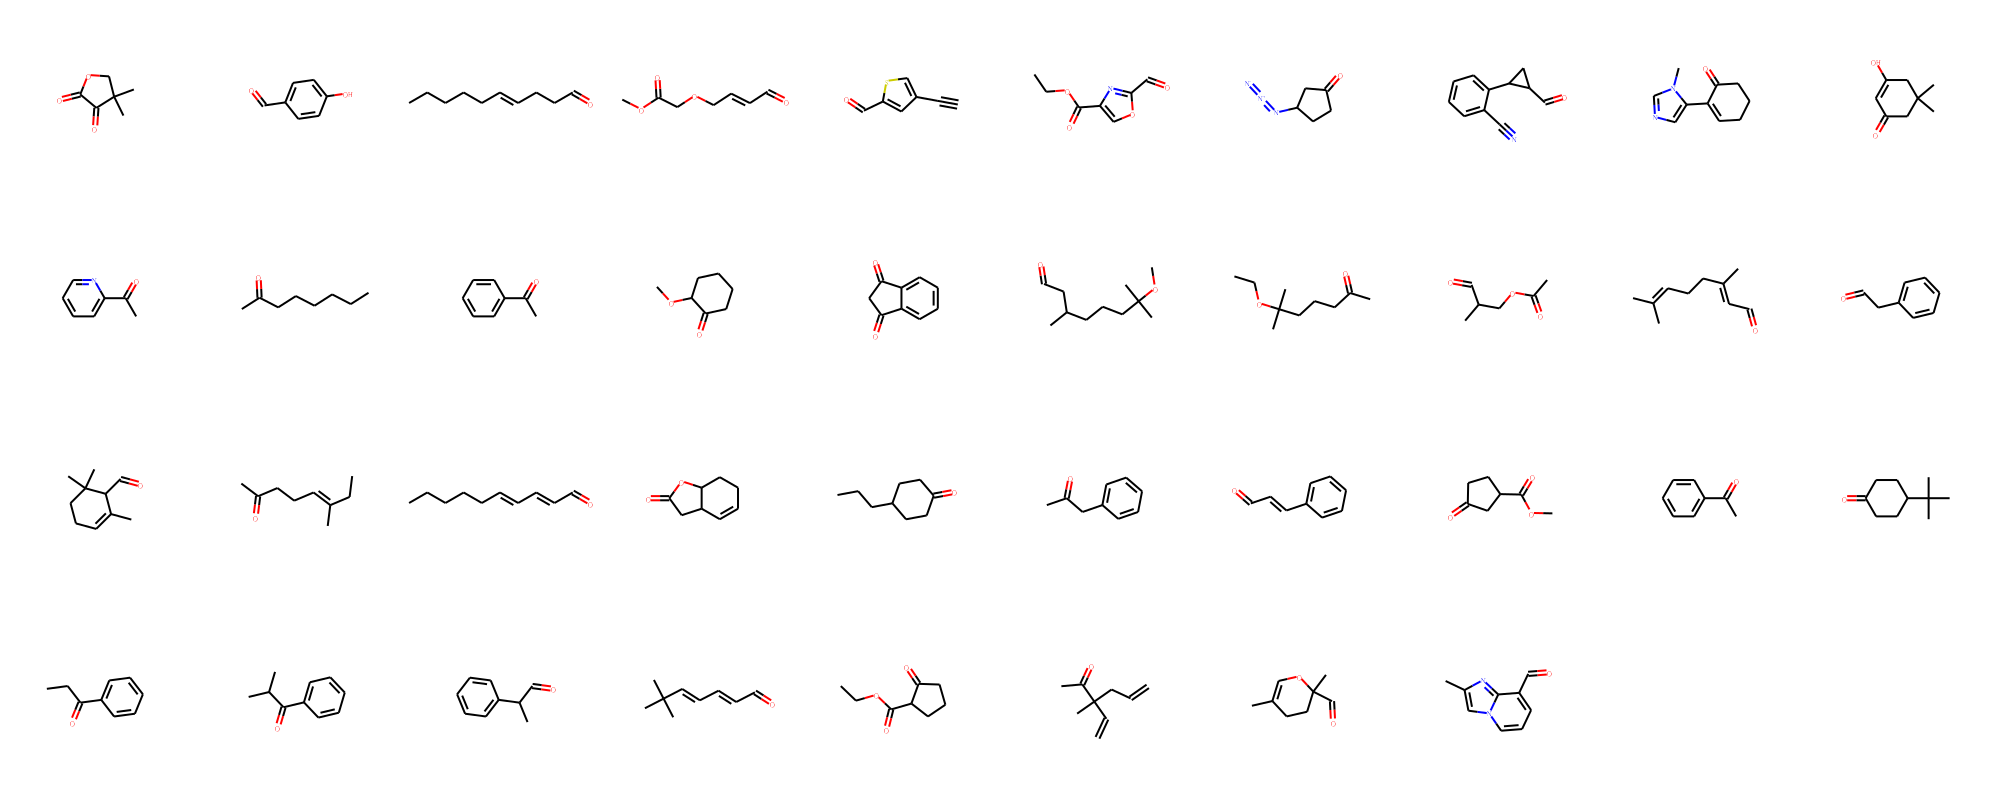

In [7]:
# Show the reactants we loaded
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in alcdhy['reactants']], molsPerRow=10, subImgSize=(200, 200))

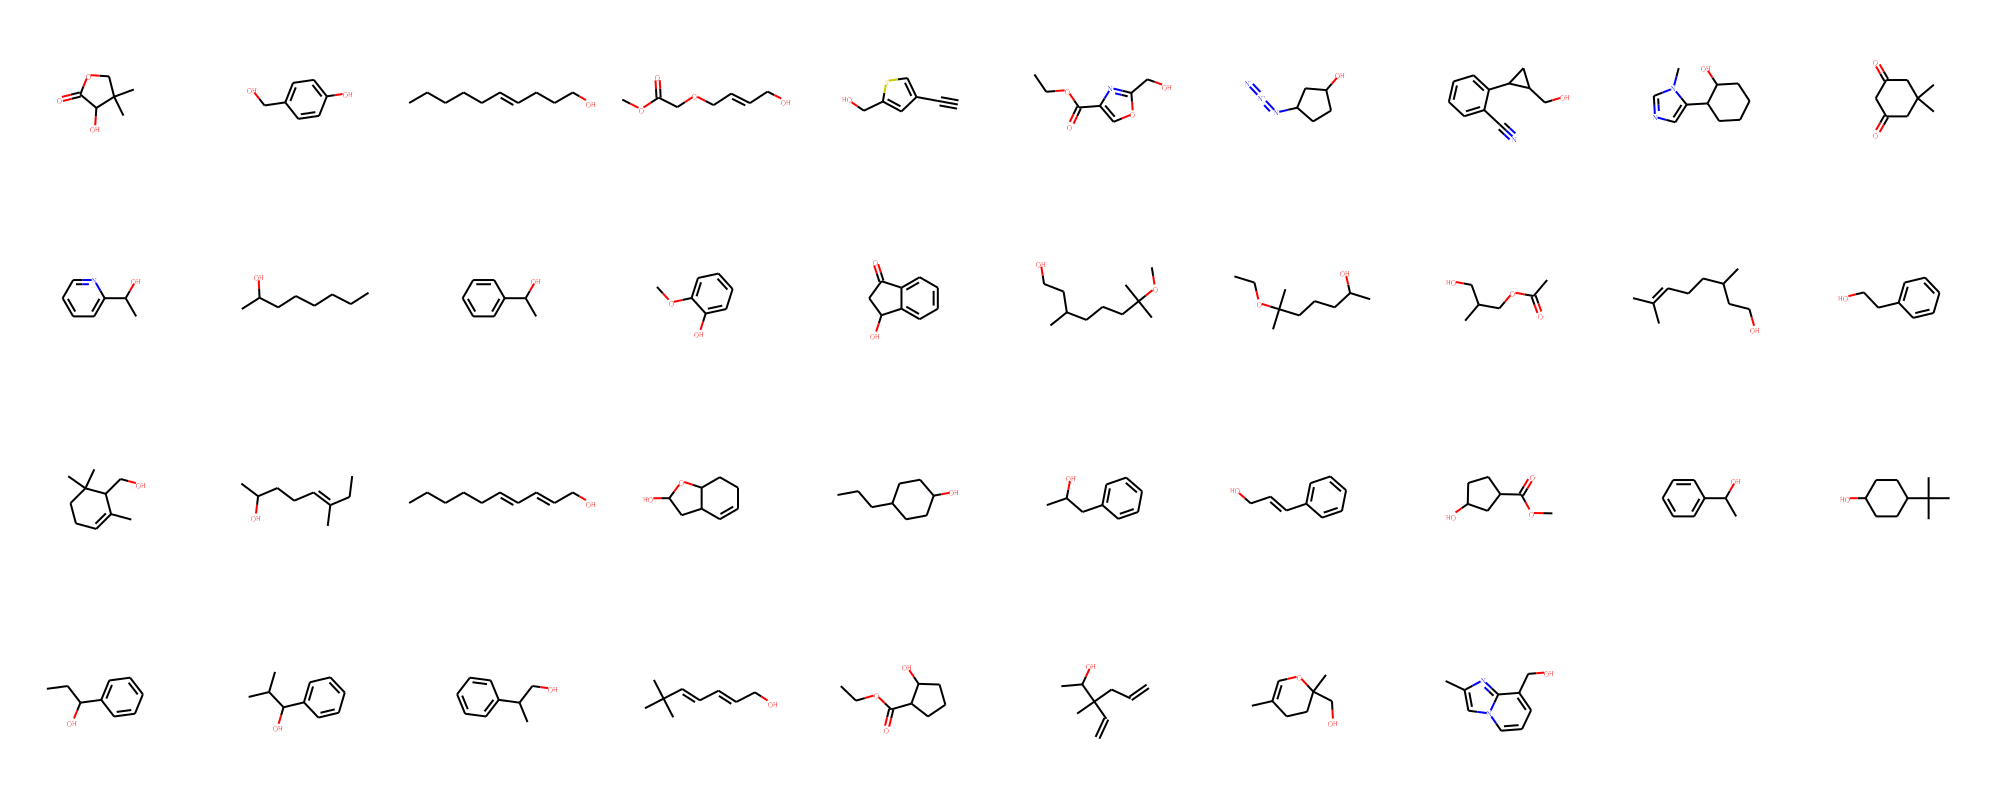

In [8]:
# Show the products we loaded
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in alcdhy['products']], molsPerRow=10, subImgSize=(200, 200))

In [9]:
# Calculate the vectors of reactants and products
rvec = [darkchem.utils.struct2vec(reactant) for reactant in alcdhy['reactants']]
pvec = [darkchem.utils.struct2vec(product) for product in alcdhy['products']]
# Transform the data type to np.array 
# For the calculation of latent space vectors
rvec = np.array(rvec).astype(int)
pvec = np.array(pvec).astype(int)

In [10]:
# Generate the latent space representation for reactants and products
r_latent = model.encoder.predict(rvec)
p_latent = model.encoder.predict(pvec)

In [11]:
# Transform the data type to DataFrame 
rvecdf = pd.DataFrame(r_latent)
pvecdf = pd.DataFrame(p_latent)

### Method

In [12]:
# Calculate the latent path vector for those 17 reactions
path = pvecdf - rvecdf

In [13]:
# Calculate the average of path vector
path_vec =np.array(path.mean().values)

In [14]:
# Calculate the average and std deviation of magnitude of path vectors
vector_magnitude(path)

The average magnitude is: 1.8204725537598967
The std magnitude is: 0.5188681715948518


In [15]:
# Calculate the average and std deviation of the angle between products and reactants vectors
vector_angle(rvecdf,pvecdf)

The average angle is: 17.146700224077833
The std angle is: 4.898315608824443


### Prediction

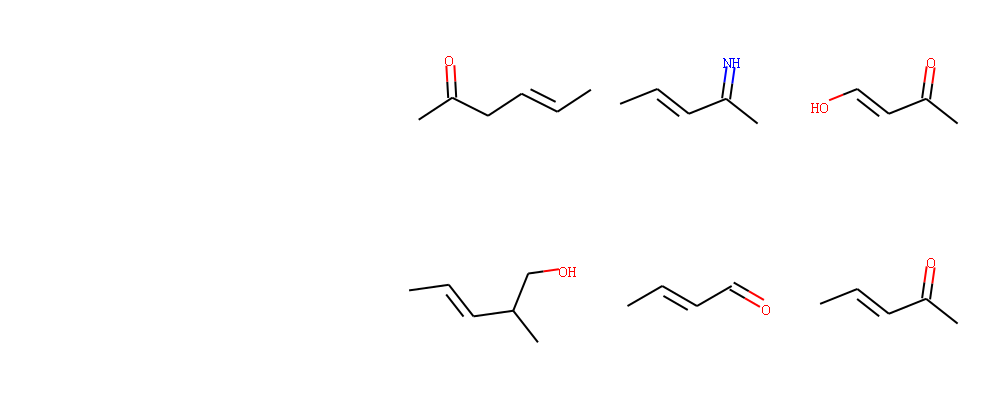

In [21]:
# Predict a certain molecule in the set which just loaded
r_p1 = 'C/C=C/C(=O)C'
rvec_p1 = [darkchem.utils.struct2vec(r_p1)]
rvec_p1 = np.array(rvec_p1).astype(int)
r_p1_latent = model.encoder.predict(rvec_p1)
p_p1_latent = r_p1_latent + path_vec
pvec_p1 = model.decoder.predict(p_p1_latent)
p_p1 = darkchem.utils.beamsearch(pvec_p1, k=10)
df = {}
df['p_p1'] = [darkchem.utils.vec2struct(i) for i in p_p1[0]]
df['p_p1_mol'] = [Chem.MolFromSmiles(df['p_p1'][i]) for i in range(len(df['p_p1']))]
img = Chem.Draw.MolsToGridImage(df['p_p1_mol'], molsPerRow=5, subImgSize=(200, 200))
img

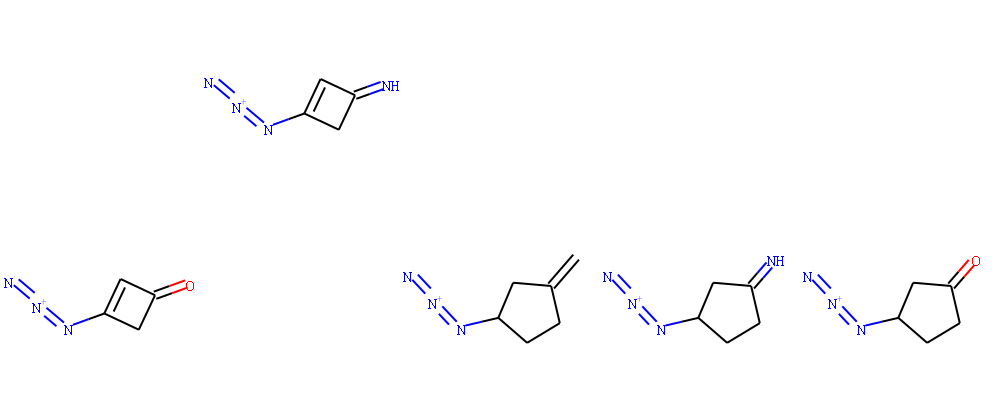

In [19]:
# Predict a certain molecule in the set which just loaded
r_p2 = '[N-]=[N+]=NC1CCC(=O)C1'
rvec_p2 = [darkchem.utils.struct2vec(r_p2)]
rvec_p2 = np.array(rvec_p2).astype(int)
r_p2_latent = model.encoder.predict(rvec_p2)
p_p2_latent = r_p2_latent + path_vec
pvec_p2 = model.decoder.predict(p_p2_latent)
p_p2 = darkchem.utils.beamsearch(pvec_p2, k=10)
df = {}
df['p_p2'] = [darkchem.utils.vec2struct(i) for i in p_p2[0]]
df['p_p2_mol'] = [Chem.MolFromSmiles(df['p_p2'][i]) for i in range(len(df['p_p2']))]
img = Chem.Draw.MolsToGridImage(df['p_p2_mol'], molsPerRow=5, subImgSize=(200, 200))
img

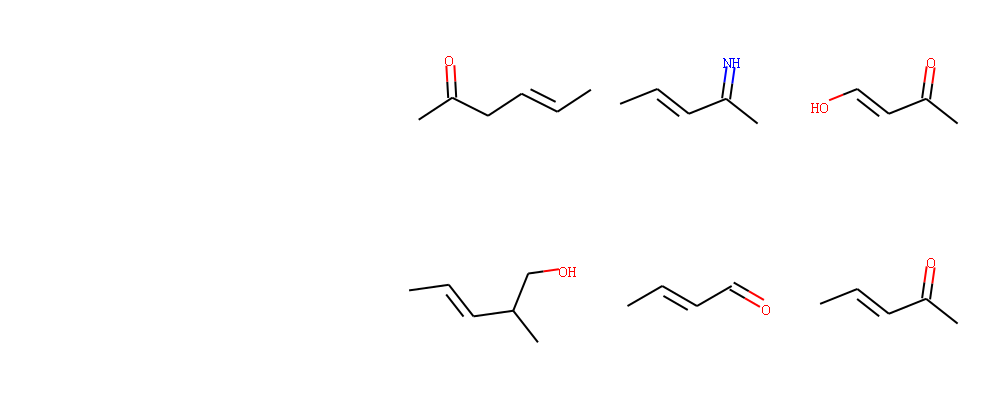

In [20]:
# Predict a certain molecule in the set which just loaded
r_p3 = 'C/C=C/C(=O)C'
rvec_p3 = [darkchem.utils.struct2vec(r_p3)]
rvec_p3 = np.array(rvec_p3).astype(int)
r_p3_latent = model.encoder.predict(rvec_p3)
p_p3_latent = r_p3_latent + path_vec
pvec_p3 = model.decoder.predict(p_p3_latent)
p_p3 = darkchem.utils.beamsearch(pvec_p3, k=10)
df = {}
df['p_p3'] = [darkchem.utils.vec2struct(i) for i in p_p3[0]]
df['p_p3_mol'] = [Chem.MolFromSmiles(df['p_p3'][i]) for i in range(len(df['p_p3']))]
img = Chem.Draw.MolsToGridImage(df['p_p3_mol'], molsPerRow=5, subImgSize=(200, 200))
img